# 基于统一相对位置采样点的高斯过程回归预测

## 1. 导入所需库

In [1]:
# 导入必要的库
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
from scipy.optimize import dual_annealing
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import glob
import warnings
from sklearn.exceptions import ConvergenceWarning

# 设置随机种子以确保可重现性
np.random.seed(123)

# 忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 设置matplotlib样式
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 创建结果保存目录
results_dir = './unified_sampling_results'
os.makedirs(results_dir, exist_ok=True)

## 2. 数据加载与预处理

在本节中，我们将从Excel文件中加载多个板材的硬度分布数据，处理可能的缺失值和异常值，并对数据进行标准化处理以便于模型训练和评估。

In [2]:
def hardness_transformation(H):
    """
    根据公式计算硬度值的变换结果 delta。
    
    参数:
        H: 硬度值 (float 或 ndarray)
        
    返回:
        delta: 变换后的值
    """
    delta = 0.67 * np.exp(-H / 0.11) - 1.49e-5 * np.exp(H / 0.10) + 0.33
    return delta

# 定义函数，用于从Excel文件中加载板材硬度分布数据
def load_plate_data(file_path):
    """
    从Excel文件中加载表格形式的硬度分布数据
    
    参数:
        file_path: Excel文件路径
        
    返回:
        包含所有工作表处理后数据的字典
    """
    sheet_names = ['A3-1-150150-4', 'A3-1-150150-8', 'A3-1-150150-14', 'A3-1-150150-21']
    all_plates_data = {}
    
    for sheet_name in sheet_names:
        try:
            # 读取原始Excel表格
            df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
            
            # 第一行包含X坐标，第一列包含Y坐标
            try:
                x_coords = pd.to_numeric(df.iloc[0, 1:].dropna(), errors='coerce').dropna().values  
                y_coords = pd.to_numeric(df.iloc[1:, 0].dropna(), errors='coerce').dropna().values
            except Exception as e:
                print(f"Error converting coordinates to numeric in sheet {sheet_name}: {e}")
                continue
                
            # 初始化列表以存储点数据
            points = []
            values = []
            x_points = []
            y_points = []
            
            # 遍历表格以提取非空硬度值
            for i in range(1, df.shape[0]):
                for j in range(1, df.shape[1]):
                    if pd.notna(df.iloc[i, j]) and pd.notna(df.iloc[i, 0]) and pd.notna(df.iloc[0, j]):
                        try:
                            # 确保所有数据转换为浮点数
                            y = float(df.iloc[i, 0])  # Y坐标来自第一列
                            x = float(df.iloc[0, j])  # X坐标来自第一行
                            value = hardness_transformation(float(df.iloc[i, j]) / 100)  # 深度值
                            
                            x_points.append(x)
                            y_points.append(y)
                            points.append([x, y])
                            values.append(value)
                        except (ValueError, TypeError):
                            # 跳过无法转换为数值的单元格
                            continue
            
            if not points:  # 如果没有有效点
                print(f"No valid data points found in sheet {sheet_name}")
                continue
                
            # 转换为NumPy数组
            points = np.array(points)
            values = np.array(values)
            x_points = np.array(x_points)
            y_points = np.array(y_points)
            
            # 标准化值
            value_min = np.min(values)
            value_max = np.max(values)
            value_normalized = (values - value_min) / (value_max - value_min)
            
            all_plates_data[sheet_name] = {
                'df': df,  # 原始数据框
                'x': x_points,
                'y': y_points,
                'value': values,
                'value_min': value_min,
                'value_max': value_max,
                'value_normalized': value_normalized,
                'points': points,
                'name': sheet_name
            }
            
            print(f"Successfully loaded {sheet_name} with {len(values)} data points")
            
        except Exception as e:
            print(f"Error loading sheet {sheet_name} from {os.path.basename(file_path)}: {e}")
    
    return all_plates_data

# 加载所有板材数据文件
data_folder = "./data/"
plate_files = glob.glob(os.path.join(data_folder, "*.xlsx"))

print(f"Found {len(plate_files)} plate data files:")
for file in plate_files:
    print(f"  - {os.path.basename(file)}")

# 加载并处理所有板材数据
plates_data = {}
for file_path in plate_files:
    file_plates = load_plate_data(file_path)
    # 将此文件中的所有工作表添加到plates_data字典
    plates_data.update(file_plates)
    
# 打印加载数据的摘要
print(f"\nLoaded {len(plates_data)} plates in total:")
for plate_name, plate_data in plates_data.items():
    print(f"\nPlate: {plate_name}")
    print(f"  Data points: {len(plate_data['value'])}")
    print(f"  Value range: {plate_data['value_min']:.2f} to {plate_data['value_max']:.2f}")
    print(f"  Average value: {np.mean(plate_data['value']):.2f}")
    print(f"  X range: {np.min(plate_data['x']):.1f} to {np.max(plate_data['x']):.1f}")
    print(f"  Y range: {np.min(plate_data['y']):.1f} to {np.max(plate_data['y']):.1f}")

Found 1 plate data files:
  - datas.xlsx
Successfully loaded A3-1-150150-4 with 323 data points
Successfully loaded A3-1-150150-8 with 359 data points
Successfully loaded A3-1-150150-14 with 132 data points
Successfully loaded A3-1-150150-21 with 312 data points

Loaded 4 plates in total:

Plate: A3-1-150150-4
  Data points: 323
  Value range: 0.06 to 0.34
  Average value: 0.18
  X range: -65.0 to 65.0
  Y range: -45.0 to 50.0

Plate: A3-1-150150-8
  Data points: 359
  Value range: 0.07 to 0.34
  Average value: 0.21
  X range: -75.0 to 75.0
  Y range: -40.0 to 40.0

Plate: A3-1-150150-14
  Data points: 132
  Value range: 0.07 to 0.32
  Average value: 0.20
  X range: -30.0 to 25.0
  Y range: -25.0 to 25.0

Plate: A3-1-150150-21
  Data points: 312
  Value range: 0.10 to 0.37
  Average value: 0.23
  X range: -65.0 to 65.0
  Y range: -40.0 to 45.0


## 3. 可视化原始数据分布

可视化图表，包括散点图、3D表面图和热力图。


Visualizing A3-1-150150-4:


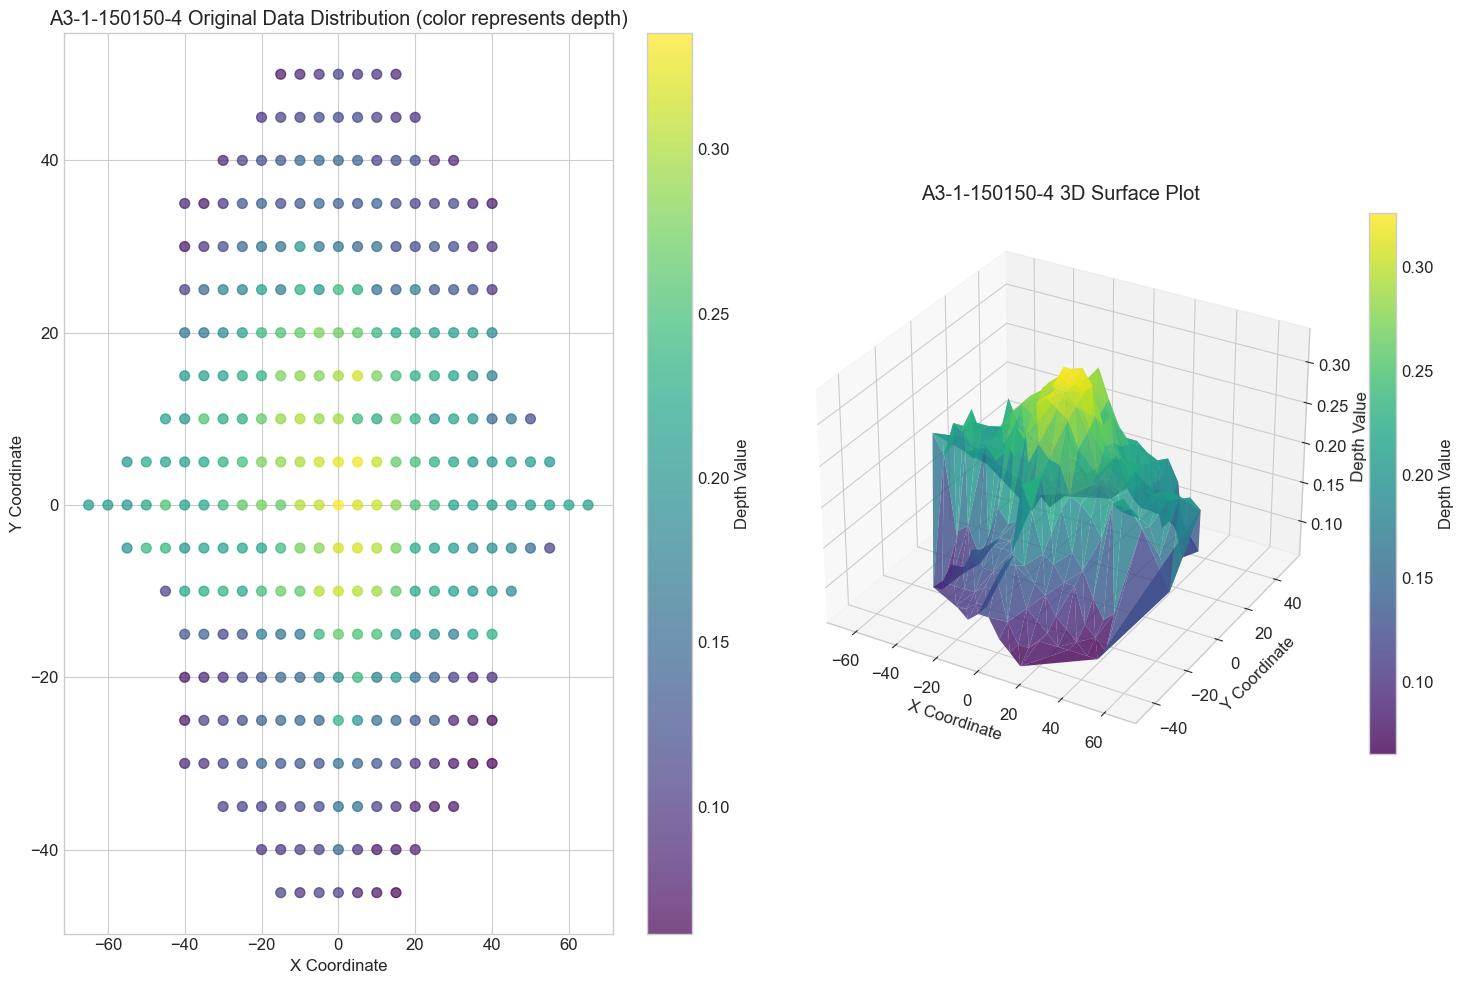


Visualizing A3-1-150150-8:


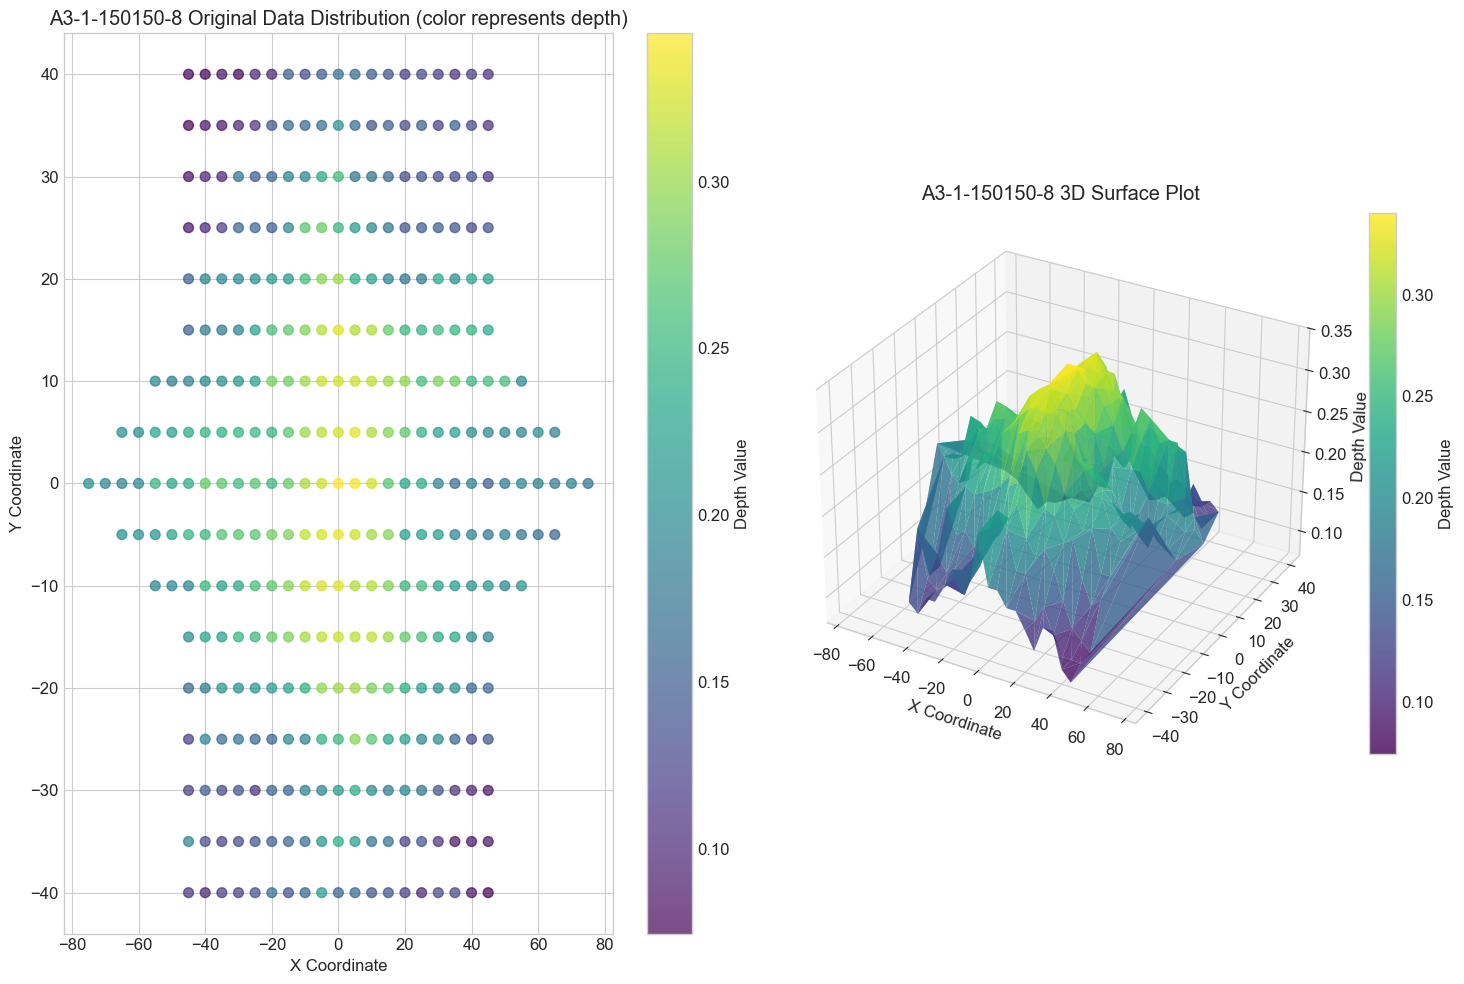


Visualizing A3-1-150150-14:


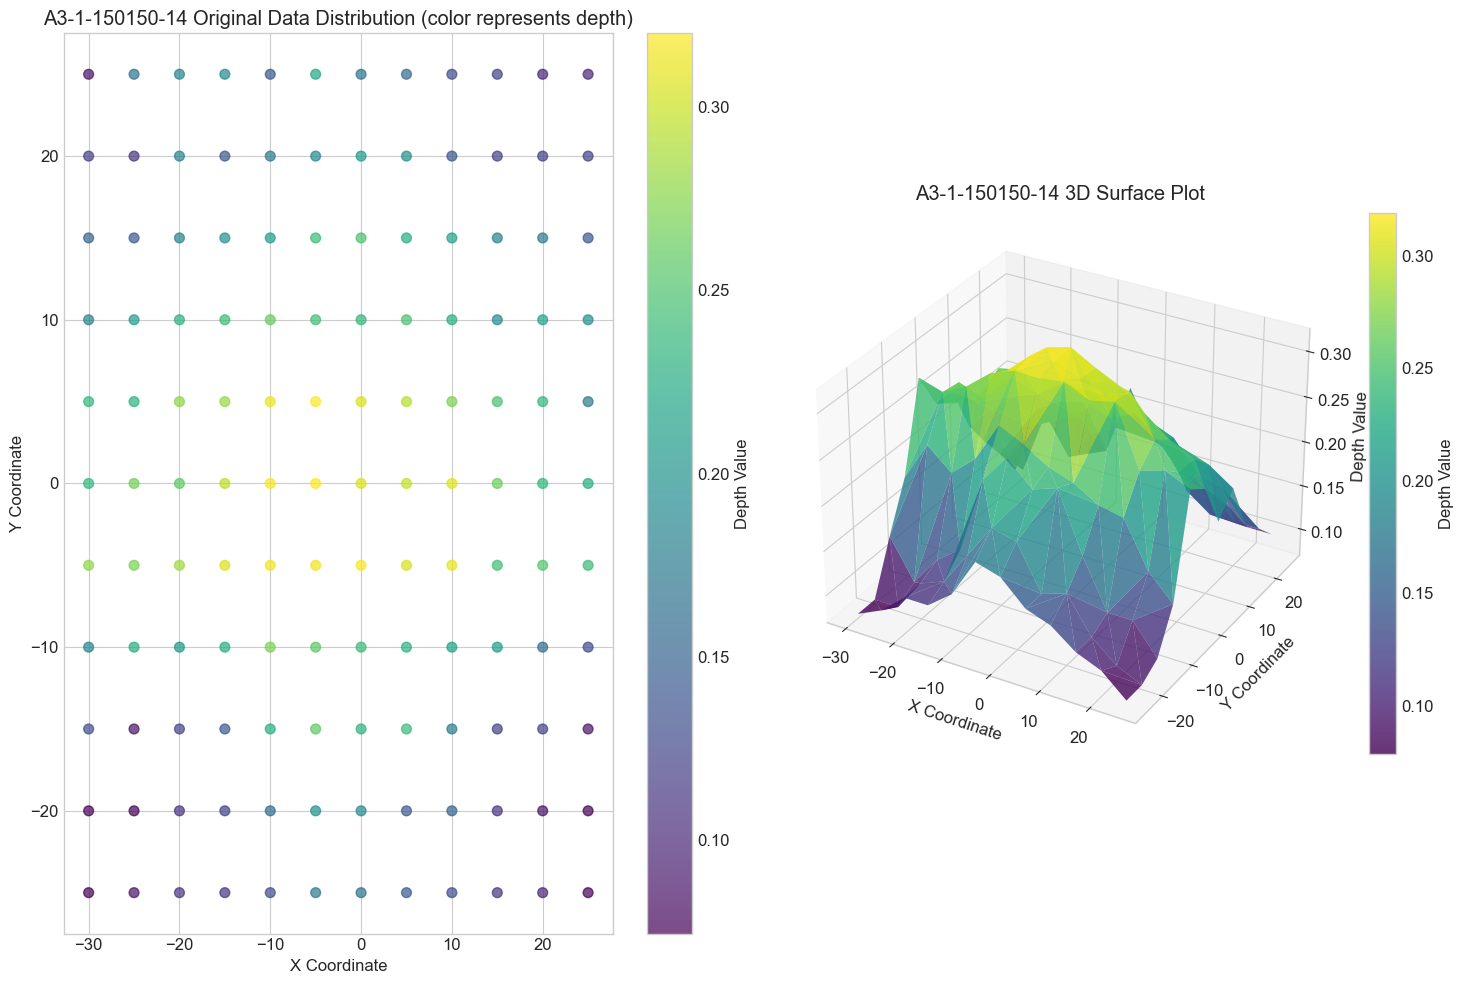


Visualizing A3-1-150150-21:


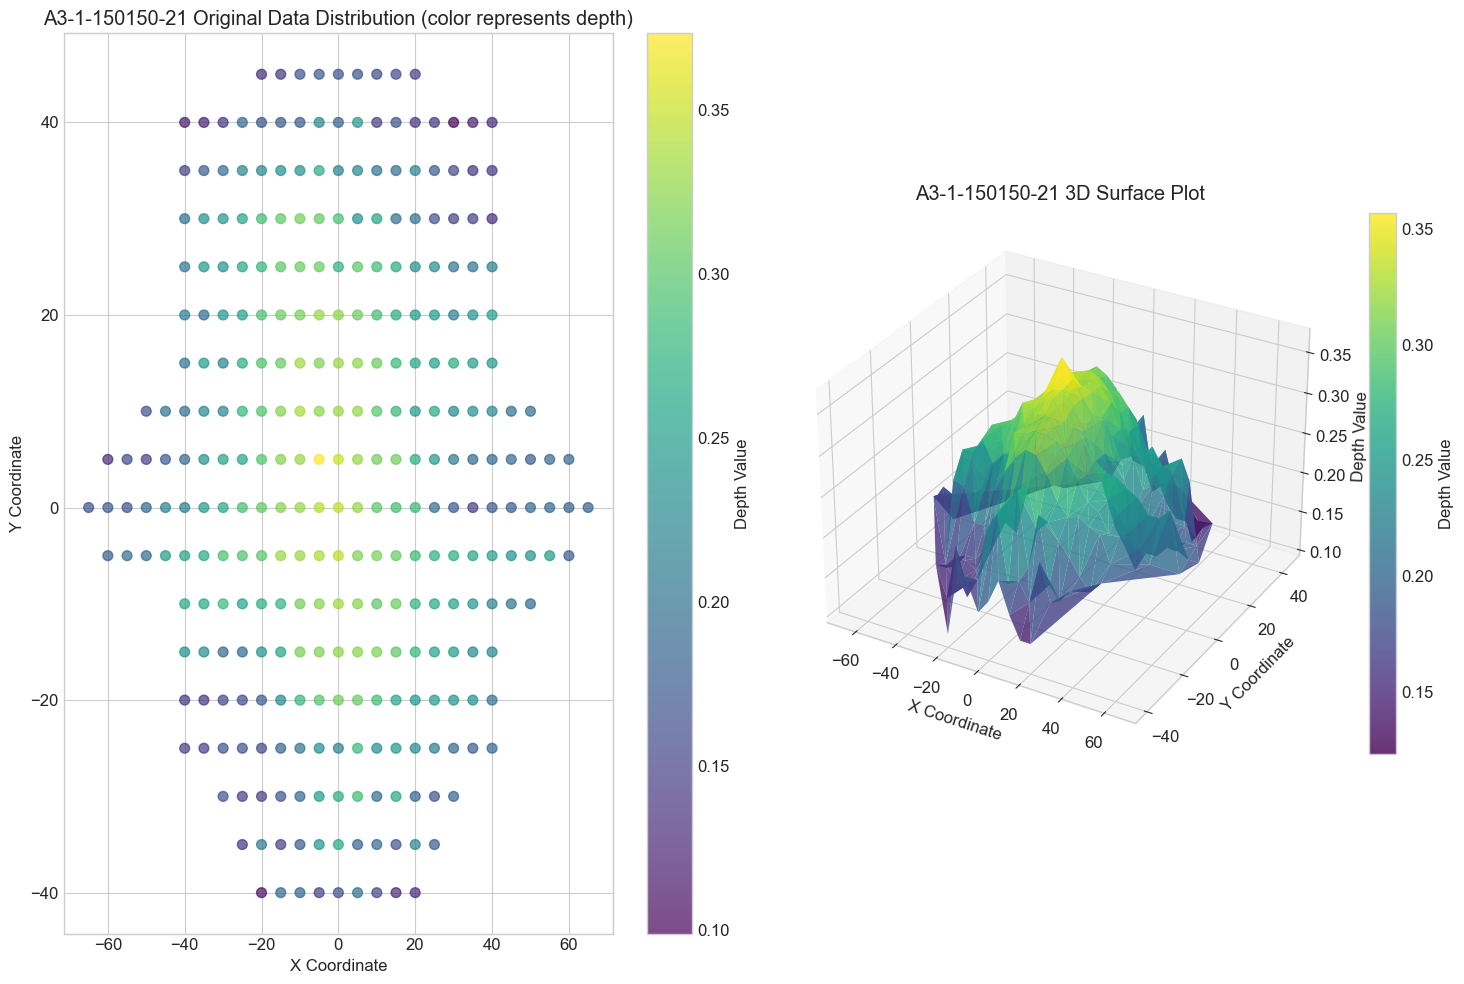

In [3]:
# Visualization function for plate data distribution
def visualize_plate_data(plate_data):
    """
    Create comprehensive visualizations for plate data
    """
    plate_name = plate_data['name']
    x = plate_data['x']
    y = plate_data['y']
    value = plate_data['value']
    
    fig = plt.figure(figsize=(15, 10))
    
    # 1. 2D scatter plot, color represents Depth value
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(x, y, c=value, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.set_title(f'{plate_name} Original Data Distribution (color represents depth)')
    ax1.grid(True)
    plt.colorbar(scatter, ax=ax1, label='Depth Value')
    
    # 2. 3D surface plot
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_trisurf(x, y, value, cmap='viridis', edgecolor='none', alpha=0.8)
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_zlabel('Depth Value')
    ax2.set_title(f'{plate_name} 3D Surface Plot')
    plt.colorbar(surf, ax=ax2, shrink=0.6, aspect=20, label='Depth Value')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'{plate_name}_original_distribution.png'), dpi=300)
    plt.show()

# Create visualizations for each plate
for plate_name, plate_data in plates_data.items():
    print(f"\nVisualizing {plate_name}:")
    visualize_plate_data(plate_data)

## 4. 高斯过程回归模型设计

高斯过程回归（GPR）是一种非参数贝叶斯方法，用于定义函数上的先验分布。GPR的基本公式为：

$$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$$

其中：
- $m(x)$ 是均值函数，表示先验期望
- $k(x, x')$ 是协方差函数（核函数），表示任意两点之间的相关性

我们将使用径向基函数（RBF）核，数学表示为：

$$k(x_i, x_j) = \sigma_f^2 \exp\left(-\frac{||x_i - x_j||^2}{2l^2}\right)$$

其中 $\sigma_f^2$ 是信号方差，$l$ 是长度尺度参数。

In [4]:
# 定义GPR模型类
class GPRModel:
    def __init__(self, kernel=None, alpha=1e-2, n_restarts_optimizer=10):
        """
        初始化GPR模型
        
        参数:
            kernel: 核函数，默认为RBF
            alpha: 用于数值稳定的噪声水平
            n_restarts_optimizer: 超参数优化重启次数
        """
        if kernel is None:
            # 默认使用RBF核，设置长度尺度界限
            self.kernel = 1.0 * RBF(length_scale=40.0, length_scale_bounds=(1e-2, 1e3))
        else:
            self.kernel = kernel
            
        self.model = GaussianProcessRegressor(
            kernel=self.kernel,
            alpha=alpha,
            n_restarts_optimizer=n_restarts_optimizer,
            random_state=123
        )
        
    def fit(self, X_train, y_train):
        """训练模型"""
        self.model.fit(X_train, y_train)
        return self
    
    def predict(self, X_test, return_std=False):
        """进行预测"""
        return self.model.predict(X_test, return_std=return_std)
    
    def score(self, X_test, y_test):
        """计算R^2分数"""
        return self.model.score(X_test, y_test)
    
    def get_kernel_params(self):
        """获取优化后的核参数"""
        return self.model.kernel_
    
    def get_log_marginal_likelihood(self):
        """获取对数边际似然"""
        return self.model.log_marginal_likelihood()

# 测试不同核函数
def test_different_kernels(X_train, y_train, X_test, y_test):
    """测试不同核函数的性能"""
    kernels = {
        'RBF': 1.0 * RBF(length_scale=40.0,length_scale_bounds=(1, 1e3))
    }
    
    results = []
    
    for name, kernel in kernels.items():
        model = GPRModel(kernel=kernel)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        nmse = mean_squared_error(y_test, y_pred) / np.var(y_test)
        kernel_params = str(model.get_kernel_params())
        log_likelihood = model.get_log_marginal_likelihood()
        
        results.append({
            'Kernel': name,
            'NMSE': nmse,
            'Log Likelihood': log_likelihood,
            'Parameters': kernel_params
        })
    
    return pd.DataFrame(results)

# 在第一个板材上测试核性能
first_plate = next(iter(plates_data.values()))
X_all = first_plate['points']
y_all = first_plate['value_normalized']

# 简单的80/20分割用于核测试
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# 测试核函数
kernel_results = test_different_kernels(X_train, y_train, X_test, y_test)
print("核函数性能测试结果:")
print(kernel_results)

核函数性能测试结果:
  Kernel     NMSE  Log Likelihood                         Parameters
0    RBF  0.08213      230.411593  0.342**2 * RBF(length_scale=28.5)


## 5. 统一相对采样点位置的定义

为了在所有板材上使用统一的采样点位置，我们需要定义相对位置坐标系，并实现坐标转换功能。通过这种方式，我们可以在不同尺寸的板材上保持一致的相对采样点布局。

开始模拟退火优化 20 个采样点位置...
迭代 1/1000: 发现更优解，NMSE = 0.213404
迭代 2/1000: 发现更优解，NMSE = 0.210526
迭代 3/1000: 发现更优解，NMSE = 0.210077
迭代 4/1000: 发现更优解，NMSE = 0.208649
迭代 100/1000: 当前温度 = 2.96, 当前NMSE = 0.280509, 最佳NMSE = 0.208649
迭代 200/1000: 当前温度 = 0.02, 当前NMSE = 0.221149, 最佳NMSE = 0.208649
迭代 236/1000: 发现更优解，NMSE = 0.201245
迭代 264/1000: 发现更优解，NMSE = 0.200138
迭代 274/1000: 发现更优解，NMSE = 0.195163
迭代 275/1000: 发现更优解，NMSE = 0.195067
迭代 288/1000: 发现更优解，NMSE = 0.194174
迭代 290/1000: 发现更优解，NMSE = 0.193166
迭代 300/1000: 当前温度 = 0.00, 当前NMSE = 0.193166, 最佳NMSE = 0.193166
迭代 317/1000: 发现更优解，NMSE = 0.190340
迭代 336/1000: 发现更优解，NMSE = 0.186848
迭代 356/1000: 发现更优解，NMSE = 0.186195
迭代 361/1000: 发现更优解，NMSE = 0.184736
迭代 372/1000: 发现更优解，NMSE = 0.184735
迭代 382/1000: 发现更优解，NMSE = 0.183964
迭代 400/1000: 当前温度 = 0.00, 当前NMSE = 0.183964, 最佳NMSE = 0.183964
迭代 433/1000: 发现更优解，NMSE = 0.183794
迭代 450/1000: 发现更优解，NMSE = 0.183639
迭代 455/1000: 发现更优解，NMSE = 0.183159
迭代 468/1000: 发现更优解，NMSE = 0.182578
迭代 500/1000: 当前温度 = 0.00, 当前NMSE =

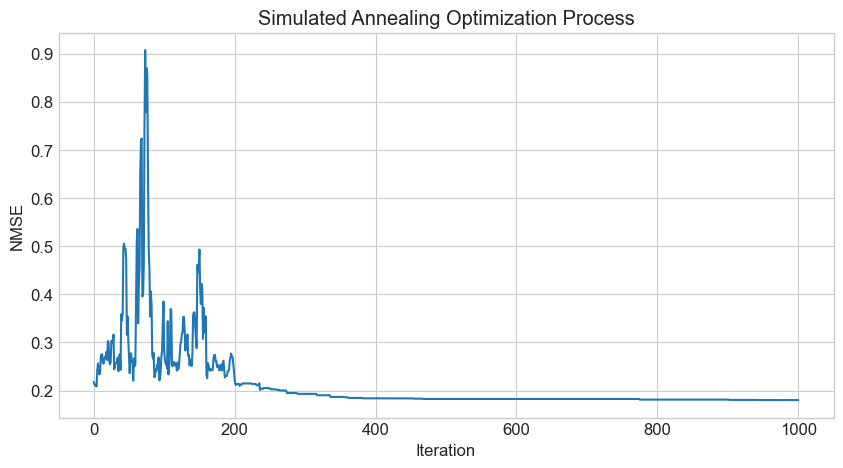

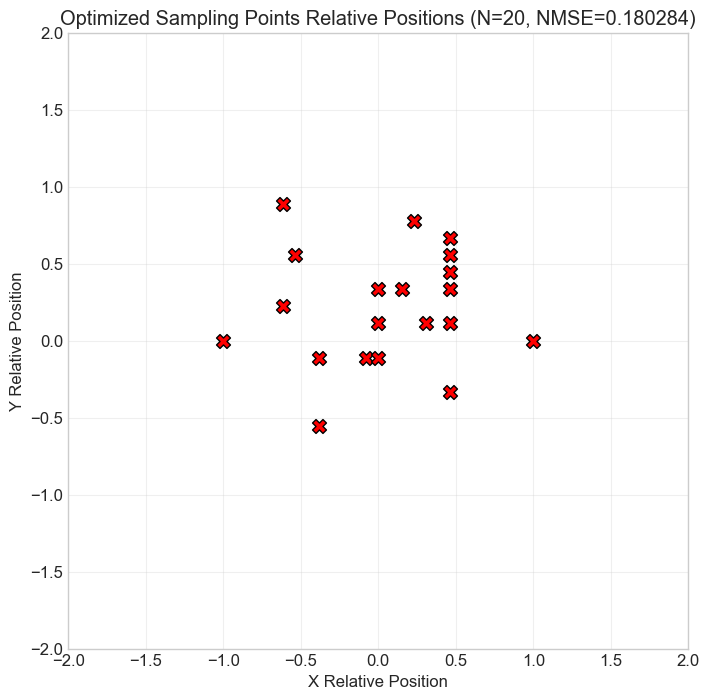

优化后的相对位置坐标:
点 1: (0.462, -0.333)
点 2: (-0.385, -0.111)
点 3: (0.231, 0.778)
点 4: (1.000, 0.000)
点 5: (0.154, 0.333)
点 6: (0.308, 0.111)
点 7: (-0.077, -0.111)
点 8: (0.000, 0.111)
点 9: (0.000, -0.111)
点 10: (-0.615, 0.222)
点 11: (0.462, 0.556)
点 12: (-0.538, 0.556)
点 13: (0.462, 0.667)
点 14: (0.000, 0.333)
点 15: (-0.385, -0.556)
点 16: (-0.615, 0.889)
点 17: (0.462, 0.333)
点 18: (0.462, 0.111)
点 19: (-1.000, 0.000)
点 20: (0.462, 0.444)


In [5]:
## 5. 模拟退火算法优化采样点位置

# 定义统一采样点数量
N_points = 20

# 定义目标函数：计算基于选定采样点的预测NMSE
def objective_function(indices, plate_data):
    """
    计算基于指定采样点的预测NMSE
    
    参数:
        indices: 采样点的索引数组
        plate_data: 板材数据
        
    返回:
        NMSE值（越小越好）
    """
    # 提取选定点的坐标和值
    X_selected = plate_data['points'][indices]
    y_selected = plate_data['value_normalized'][indices]
    
    # 训练GPR模型
    kernel = 1.0 * RBF(length_scale=40.0, length_scale_bounds=(1e-2, 1e3))
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-2,
        n_restarts_optimizer=5,
        random_state=123
    )
    
    try:
        model.fit(X_selected, y_selected)
        # 预测整个场
        y_pred = model.predict(plate_data['points'])
        # 计算NMSE
        nmse = mean_squared_error(plate_data['value_normalized'], y_pred) / np.var(plate_data['value_normalized'])
        return nmse
    except Exception as e:
        print(f"模型训练失败: {e}")
        return np.inf  

# 实现模拟退火算法优化采样点位置
def simulated_annealing_optimization(plate_data, n_points=20, max_iter=1000, 
                                    initial_temp=100, cooling_rate=0.95, 
                                    n_neighbors=3):
    """
    使用模拟退火算法优化采样点位置
    
    参数:
        plate_data: 板材数据
        n_points: 采样点数量
        max_iter: 最大迭代次数
        initial_temp: 初始温度
        cooling_rate: 冷却率
        n_neighbors: 邻域范围（每次替换的点数）
        
    返回:
        最佳采样点索引数组
    """
    print(f"开始模拟退火优化 {n_points} 个采样点位置...")
    
    # 获取数据总数
    n_total_points = len(plate_data['points'])
    
    # 随机初始化采样点索引
    current_solution = np.random.choice(n_total_points, size=n_points, replace=False)
    current_energy = objective_function(current_solution, plate_data)
    
    # 初始化最佳解
    best_solution = current_solution.copy()
    best_energy = current_energy
    
    # 初始化温度
    temp = initial_temp
    
    # 记录能量历史，用于可视化
    energy_history = [current_energy]
    
    # 开始模拟退火迭代
    for i in range(max_iter):
        # 创建新的候选解
        candidate_solution = current_solution.copy()
        
        # 随机替换1-n_neighbors个点
        n_replace = np.random.randint(1, n_neighbors+1)
        indices_to_replace = np.random.choice(n_points, size=n_replace, replace=False)
        
        # 选择不在当前解中的点进行替换
        available_indices = np.setdiff1d(np.arange(n_total_points), current_solution)
        
        if len(available_indices) >= n_replace:
            new_indices = np.random.choice(available_indices, size=n_replace, replace=False)
            candidate_solution[indices_to_replace] = new_indices
            
            # 计算新解的能量
            candidate_energy = objective_function(candidate_solution, plate_data)
            
            # 计算能量差
            delta_e = candidate_energy - current_energy
            
            # Metropolis准则：接受更好的解或以一定概率接受较差的解
            if delta_e < 0 or np.random.random() < np.exp(-delta_e / temp):
                current_solution = candidate_solution
                current_energy = candidate_energy
                
                # 更新最佳解
                if current_energy < best_energy:
                    best_solution = current_solution.copy()
                    best_energy = current_energy
                    print(f"迭代 {i+1}/{max_iter}: 发现更优解，NMSE = {best_energy:.6f}")
        
        # 记录当前能量
        energy_history.append(current_energy)
        
        # 降低温度
        temp = temp * cooling_rate
        
        # 每100次迭代输出一次进度
        if (i+1) % 100 == 0:
            print(f"迭代 {i+1}/{max_iter}: 当前温度 = {temp:.2f}, 当前NMSE = {current_energy:.6f}, 最佳NMSE = {best_energy:.6f}")
    
    print(f"优化完成: 最佳NMSE = {best_energy:.6f}")
    
    # 可视化优化过程
    plt.figure(figsize=(10, 5))
    plt.plot(energy_history)
    plt.title('Simulated Annealing Optimization Process')
    plt.xlabel('Iteration')
    plt.ylabel('NMSE')
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, 'sa_optimization_process.png'), dpi=300)
    plt.show()
    
    return best_solution, best_energy

# 在参考板材上使用模拟退火算法优化采样点
reference_plate_name = 'A3-1-150150-21'  
reference_plate = plates_data[reference_plate_name]

# 运行模拟退火优化
best_indices, best_nmse = simulated_annealing_optimization(
    reference_plate, 
    n_points=N_points,
    max_iter=1000,  # 可根据需要调整
    initial_temp=500.0,
    cooling_rate=0.95,
    n_neighbors=2
)

# 获取最优采样点的坐标
best_points = reference_plate['points'][best_indices]

# 将最佳采样点坐标转换为相对位置
def convert_to_relative_position(plate_data, points):
    """将绝对坐标转换为相对坐标（0-1范围内）
    """
    # 获取板材的坐标极值
    x_min, x_max = np.min(plate_data['x']), np.max(plate_data['x'])
    y_min, y_max = np.min(plate_data['y']), np.max(plate_data['y'])
    
    # 计算最大绝对值坐标，用于归一化
    x_abs_max = max(abs(x_min), abs(x_max))
    y_abs_max = max(abs(y_min), abs(y_max))
    
    # 归一化坐标，保持原点(0,0)不变
    x_relative = points[:, 0] / x_abs_max if x_abs_max != 0 else points[:, 0]
    y_relative = points[:, 1] / y_abs_max if y_abs_max != 0 else points[:, 1]
    
    return np.column_stack((x_relative, y_relative))
# 将最佳采样点转换为相对位置
relative_positions = convert_to_relative_position(reference_plate, best_points)

# 可视化最佳采样点的相对位置
plt.figure(figsize=(8, 8))
plt.scatter(relative_positions[:, 0], relative_positions[:, 1], c='red', 
            s=100, marker='X', edgecolor='black')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True, alpha=0.3)
plt.title(f'Optimized Sampling Points Relative Positions (N={N_points}, NMSE={best_nmse:.6f})')
plt.xlabel('X Relative Position')
plt.ylabel('Y Relative Position')
plt.savefig(os.path.join(results_dir, 'optimized_relative_positions.png'), dpi=300)
plt.show()

print("优化后的相对位置坐标:")
for i, pos in enumerate(relative_positions):
    print(f"点 {i+1}: ({pos[0]:.3f}, {pos[1]:.3f})")

## 6. 基于统一相对位置的预测

使用统一相对位置的采样点，我们将对每个板材进行GPR模型训练和预测。

In [6]:
# 定义用于相对位置转换为绝对位置的函数
def convert_to_absolute_position(plate_data, relative_positions):
    """将相对坐标转换为绝对坐标，保持原点(0,0)不变
    
    参数:
        plate_data: 板材数据字典
        relative_positions: 相对位置坐标数组
        
    返回:
        绝对位置坐标数组
    """
    # 获取板材的坐标极值
    x_min, x_max = np.min(plate_data['x']), np.max(plate_data['x'])
    y_min, y_max = np.min(plate_data['y']), np.max(plate_data['y'])
    
    # 计算最大绝对值坐标，用于反归一化
    x_abs_max = max(abs(x_min), abs(x_max))
    y_abs_max = max(abs(y_min), abs(y_max))
    
    # 将相对坐标转换回绝对坐标
    x_absolute = relative_positions[:, 0] * x_abs_max
    y_absolute = relative_positions[:, 1] * y_abs_max
    
    return np.column_stack((x_absolute, y_absolute))
    

# 定义用于查找最近点索引的函数
def find_nearest_point_indices(plate_data, target_positions):
    """在板材上查找与目标位置最近的实际数据点的索引
    
    参数:
        plate_data: 板材数据字典
        target_positions: 目标位置坐标数组
        
    返回:
        最接近的实际数据点的索引数组
    """
    # 获取所有数据点的坐标
    all_points = plate_data['points']
    
    # 初始化索引数组
    nearest_indices = []
    
    # 对每个目标点，找到最接近的实际数据点
    for target in target_positions:
        # 计算目标点到所有数据点的欧氏距离
        distances = np.sqrt(np.sum((all_points - target)**2, axis=1))
        
        # 找到距离最小的点的索引
        nearest_idx = np.argmin(distances)
        nearest_indices.append(nearest_idx)
    
    return np.array(nearest_indices)

In [7]:
# 将模拟退火优化的相对位置应用到所有板材并训练模型
optimized_results = {}

for plate_name, plate_data in plates_data.items():
    print(f"\n为{plate_name}应用优化的采样点位置")
    
    # 将相对位置转换为此板材上的绝对位置
    absolute_positions = convert_to_absolute_position(plate_data, relative_positions)
    
    # 找到最接近的实际数据点
    optimized_indices = find_nearest_point_indices(plate_data, absolute_positions)
    
    # 确保没有重复点（如果有，则选择替代点）
    unique_indices = []
    used_indices = set()
    all_indices = set(range(len(plate_data['points'])))
    
    for idx in optimized_indices:
        if idx not in used_indices:
            unique_indices.append(idx)
            used_indices.add(idx)
        else:
            # 如果有重复，选择最接近的未使用点
            available_indices = list(all_indices - used_indices)
            if available_indices:  # 确保还有可用点
                # 选择最近的未使用点
                point = plate_data['points'][idx]
                distances = np.sqrt(np.sum((plate_data['points'][available_indices] - point)**2, axis=1))
                closest_available_idx = available_indices[np.argmin(distances)]
                unique_indices.append(closest_available_idx)
                used_indices.add(closest_available_idx)
    
    optimized_indices = np.array(unique_indices)
    
    # 获取这些点的坐标和值
    optimized_points = plate_data['points'][optimized_indices]
    optimized_values = plate_data['value_normalized'][optimized_indices]
    
    # 训练GPR模型
    gpr_model = GPRModel()
    gpr_model.fit(optimized_points, optimized_values)
    
    # 预测整个字段
    y_pred_normalized = gpr_model.predict(plate_data['points'])
    y_pred = y_pred_normalized * (plate_data['value_max'] - plate_data['value_min']) + plate_data['value_min']
    
    # 计算误差
    absolute_error = np.abs(plate_data['value'] - y_pred)
    relative_error = absolute_error / (plate_data['value_max'] - plate_data['value_min']) * 100
    nmse = mean_squared_error(plate_data['value_normalized'], y_pred_normalized) / np.var(plate_data['value_normalized'])
    
    # 保存结果
    optimized_results[plate_name] = {
        'optimized_indices': optimized_indices,
        'optimized_points': optimized_points,
        'optimized_values': plate_data['value'][optimized_indices],
        'y_pred': y_pred,
        'y_pred_normalized': y_pred_normalized,
        'absolute_error': absolute_error,
        'relative_error': relative_error,
        'nmse': nmse,
        'gpr_model': gpr_model
    }
    
    print(f"  使用优化采样点的NMSE: {nmse:.6f}")
    print(f"  绝对误差 (平均): {np.mean(absolute_error):.4f}")
    print(f"  绝对误差 (最大): {np.max(absolute_error):.4f}")
    print(f"  相对误差 (平均): {np.mean(relative_error):.2f}%")
    
    # 保存采样点数据到CSV
    sample_df = pd.DataFrame({
        'x': optimized_points[:, 0],
        'y': optimized_points[:, 1],
        'value': plate_data['value'][optimized_indices]
    })
    sample_df.to_csv(os.path.join(results_dir, f'{plate_name}_optimized_points.csv'), index=False)


为A3-1-150150-4应用优化的采样点位置
  使用优化采样点的NMSE: 0.169180
  绝对误差 (平均): 0.0224
  绝对误差 (最大): 0.0787
  相对误差 (平均): 8.16%

为A3-1-150150-8应用优化的采样点位置
  使用优化采样点的NMSE: 0.219530
  绝对误差 (平均): 0.0248
  绝对误差 (最大): 0.0866
  相对误差 (平均): 9.20%

为A3-1-150150-14应用优化的采样点位置
  使用优化采样点的NMSE: 0.304833
  绝对误差 (平均): 0.0291
  绝对误差 (最大): 0.1260
  相对误差 (平均): 11.86%

为A3-1-150150-21应用优化的采样点位置
  使用优化采样点的NMSE: 0.180284
  绝对误差 (平均): 0.0199
  绝对误差 (最大): 0.0835
  相对误差 (平均): 7.26%


## 7. 性能评估与NMSE计算

归一化均方误差（NMSE）是评估预测模型性能的有用指标，其计算方式为：

$$NMSE = \frac{MSE}{\sigma^2_y} = \frac{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2}$$

其中：
- $y_i$ 是真实值
- $\hat{y}_i$ 是预测值
- $\bar{y}$ 是真实值的平均值
- $\sigma^2_y$ 是真实值的方差

NMSE特性：
- NMSE = 0 表示完美预测
- NMSE = 1 表示性能等同于简单预测均值
- NMSE > 1 表示性能比预测均值还差


Performance Evaluation Results:
            Plate      NMSE  Mean Absolute Error  Max Absolute Error  \
0   A3-1-150150-4  0.169180             0.022367            0.078742   
1   A3-1-150150-8  0.219530             0.024824            0.086578   
2  A3-1-150150-14  0.304833             0.029129            0.125987   
3  A3-1-150150-21  0.180284             0.019947            0.083544   

   Mean Relative Error (%)  Max Relative Error (%)  
0                 8.164648               28.743030  
1                 9.195312               32.070729  
2                11.861549               51.302706  
3                 7.261707               30.414229  


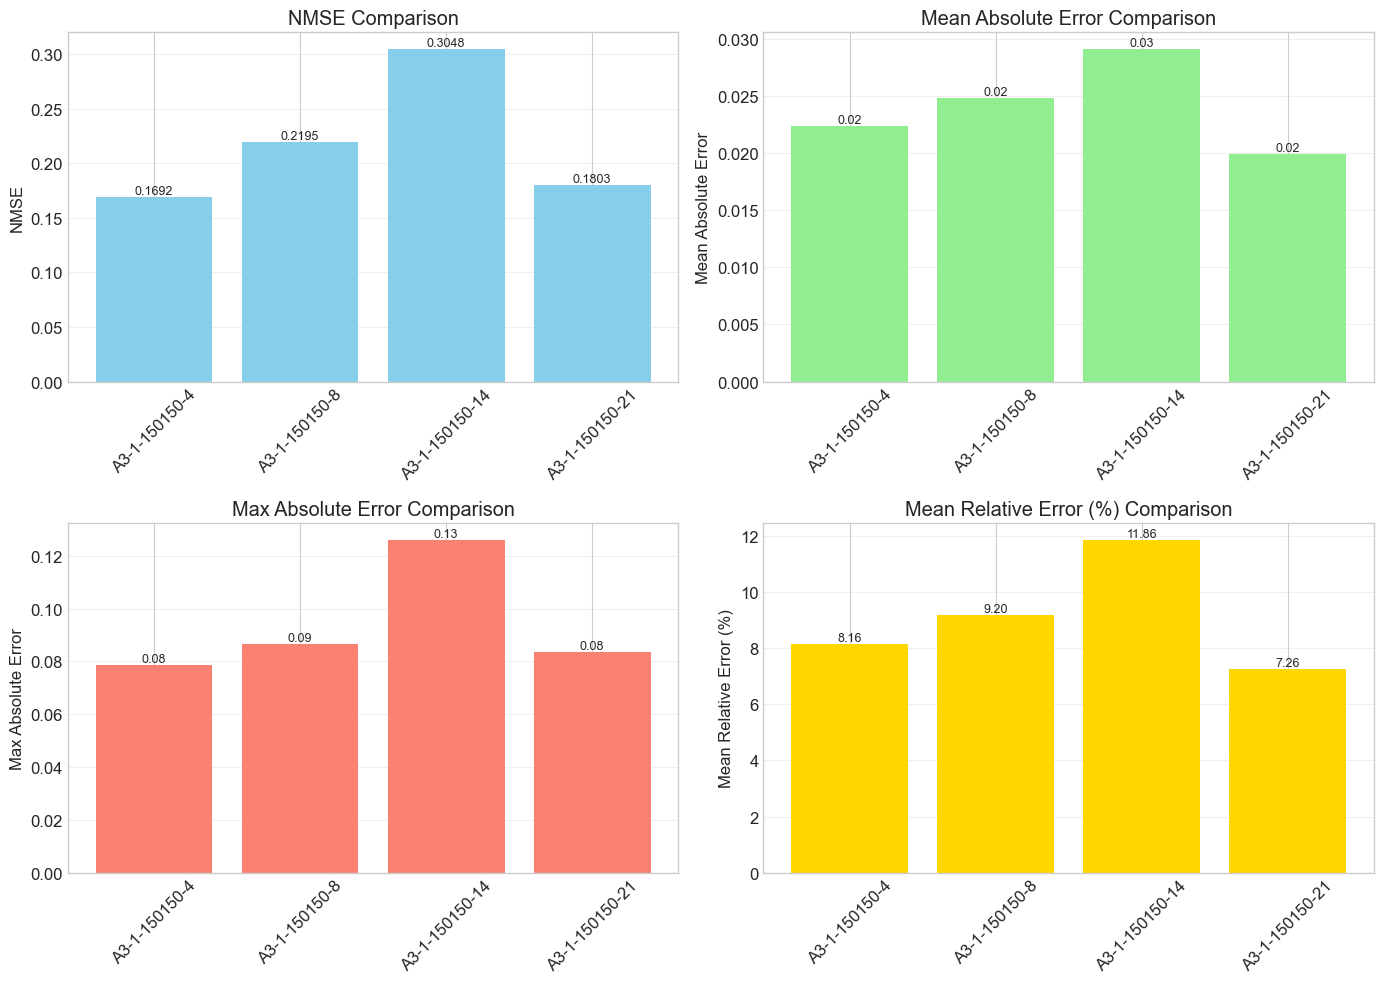

In [8]:
# Create performance evaluation table
performance_results = {
    'Plate': [],
    'NMSE': [],
    'Mean Absolute Error': [],
    'Max Absolute Error': [],
    'Mean Relative Error (%)': [],
    'Max Relative Error (%)': []
}

for plate_name, result in optimized_results.items():
    performance_results['Plate'].append(plate_name)
    performance_results['NMSE'].append(result['nmse'])
    performance_results['Mean Absolute Error'].append(np.mean(result['absolute_error']))
    performance_results['Max Absolute Error'].append(np.max(result['absolute_error']))
    performance_results['Mean Relative Error (%)'].append(np.mean(result['relative_error']))
    performance_results['Max Relative Error (%)'].append(np.max(result['relative_error']))

# Create performance table
performance_df = pd.DataFrame(performance_results)
print("\nPerformance Evaluation Results:")
print(performance_df)

# Save results to CSV
performance_df.to_csv(os.path.join(results_dir, 'performance_metrics.csv'), index=False)

# Create performance metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['NMSE', 'Mean Absolute Error', 'Max Absolute Error', 'Mean Relative Error (%)']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes.flatten()[i]
    ax.bar(performance_df['Plate'], performance_df[metric], color=color)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    
    # Add value labels on each bar
    for j, value in enumerate(performance_df[metric]):
        ax.text(j, value, f'{value:.4f}' if metric == 'NMSE' else f'{value:.2f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'performance_metrics_comparison.png'), dpi=300)
plt.show()

## 8. 结果可视化与分析

为了全面理解统一采样点方法的效果，我们将创建详细的可视化，包括原始分布与预测分布的对比，误差分布图，以及所选采样点的位置。


Generating visualizations for A3-1-150150-4...


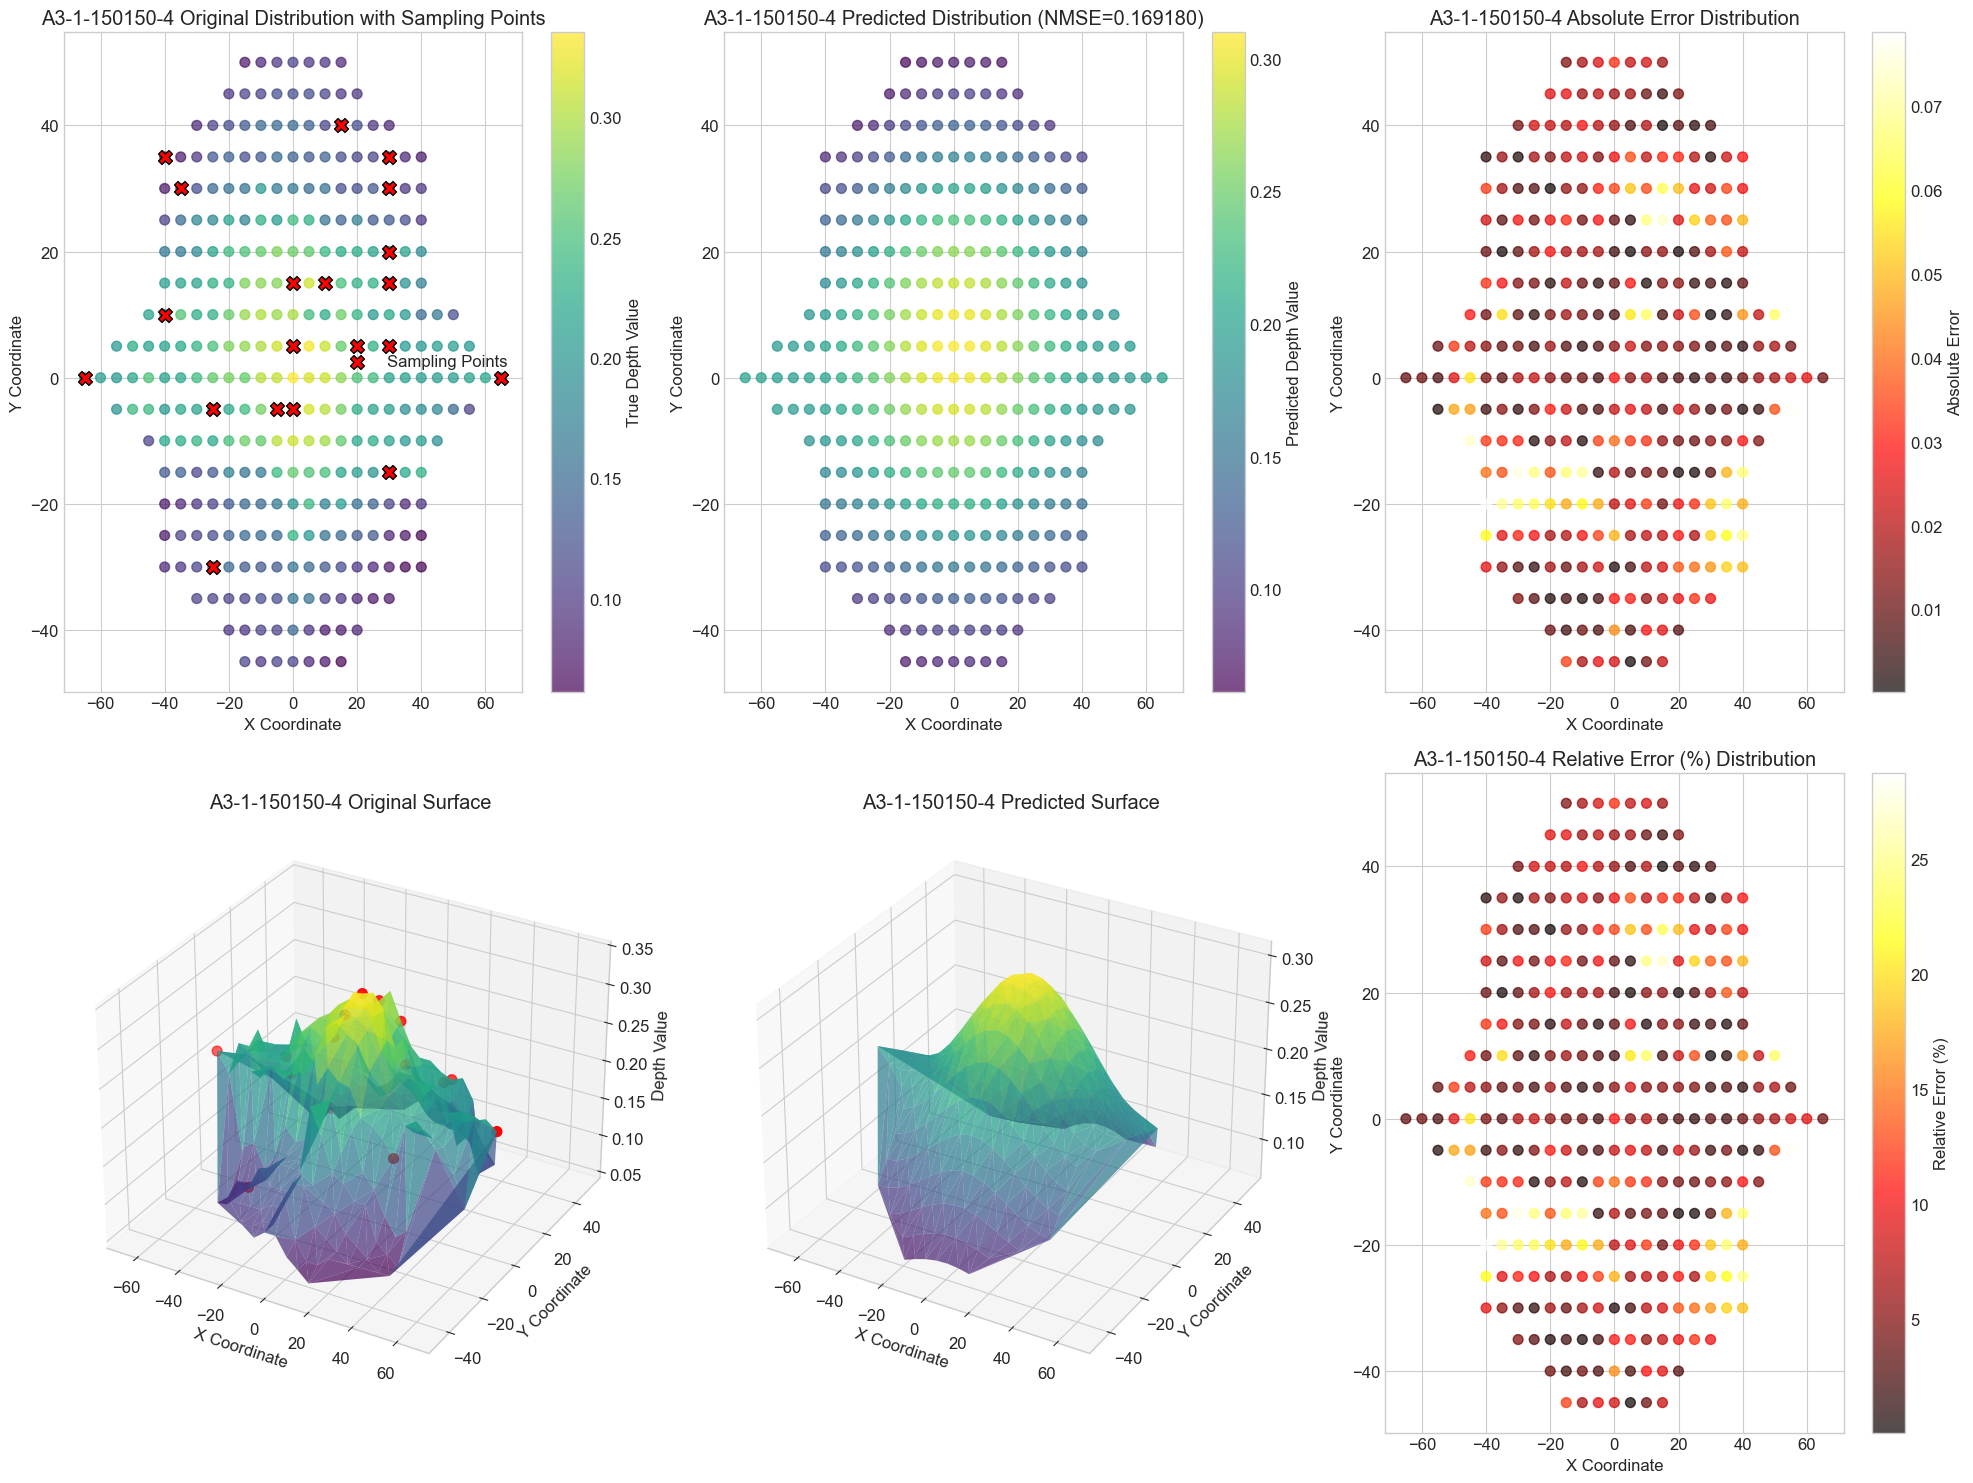

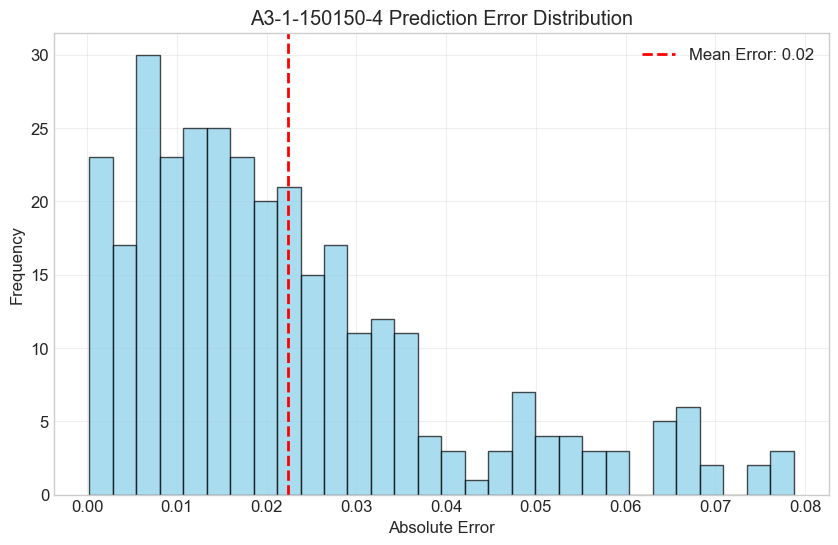


Error Statistics for A3-1-150150-4:
                    Metric      Value
0                     NMSE   0.169180
1      Mean Absolute Error   0.022367
2       Max Absolute Error   0.078742
3  Mean Relative Error (%)   8.164648
4   Max Relative Error (%)  28.743030

Generating visualizations for A3-1-150150-8...


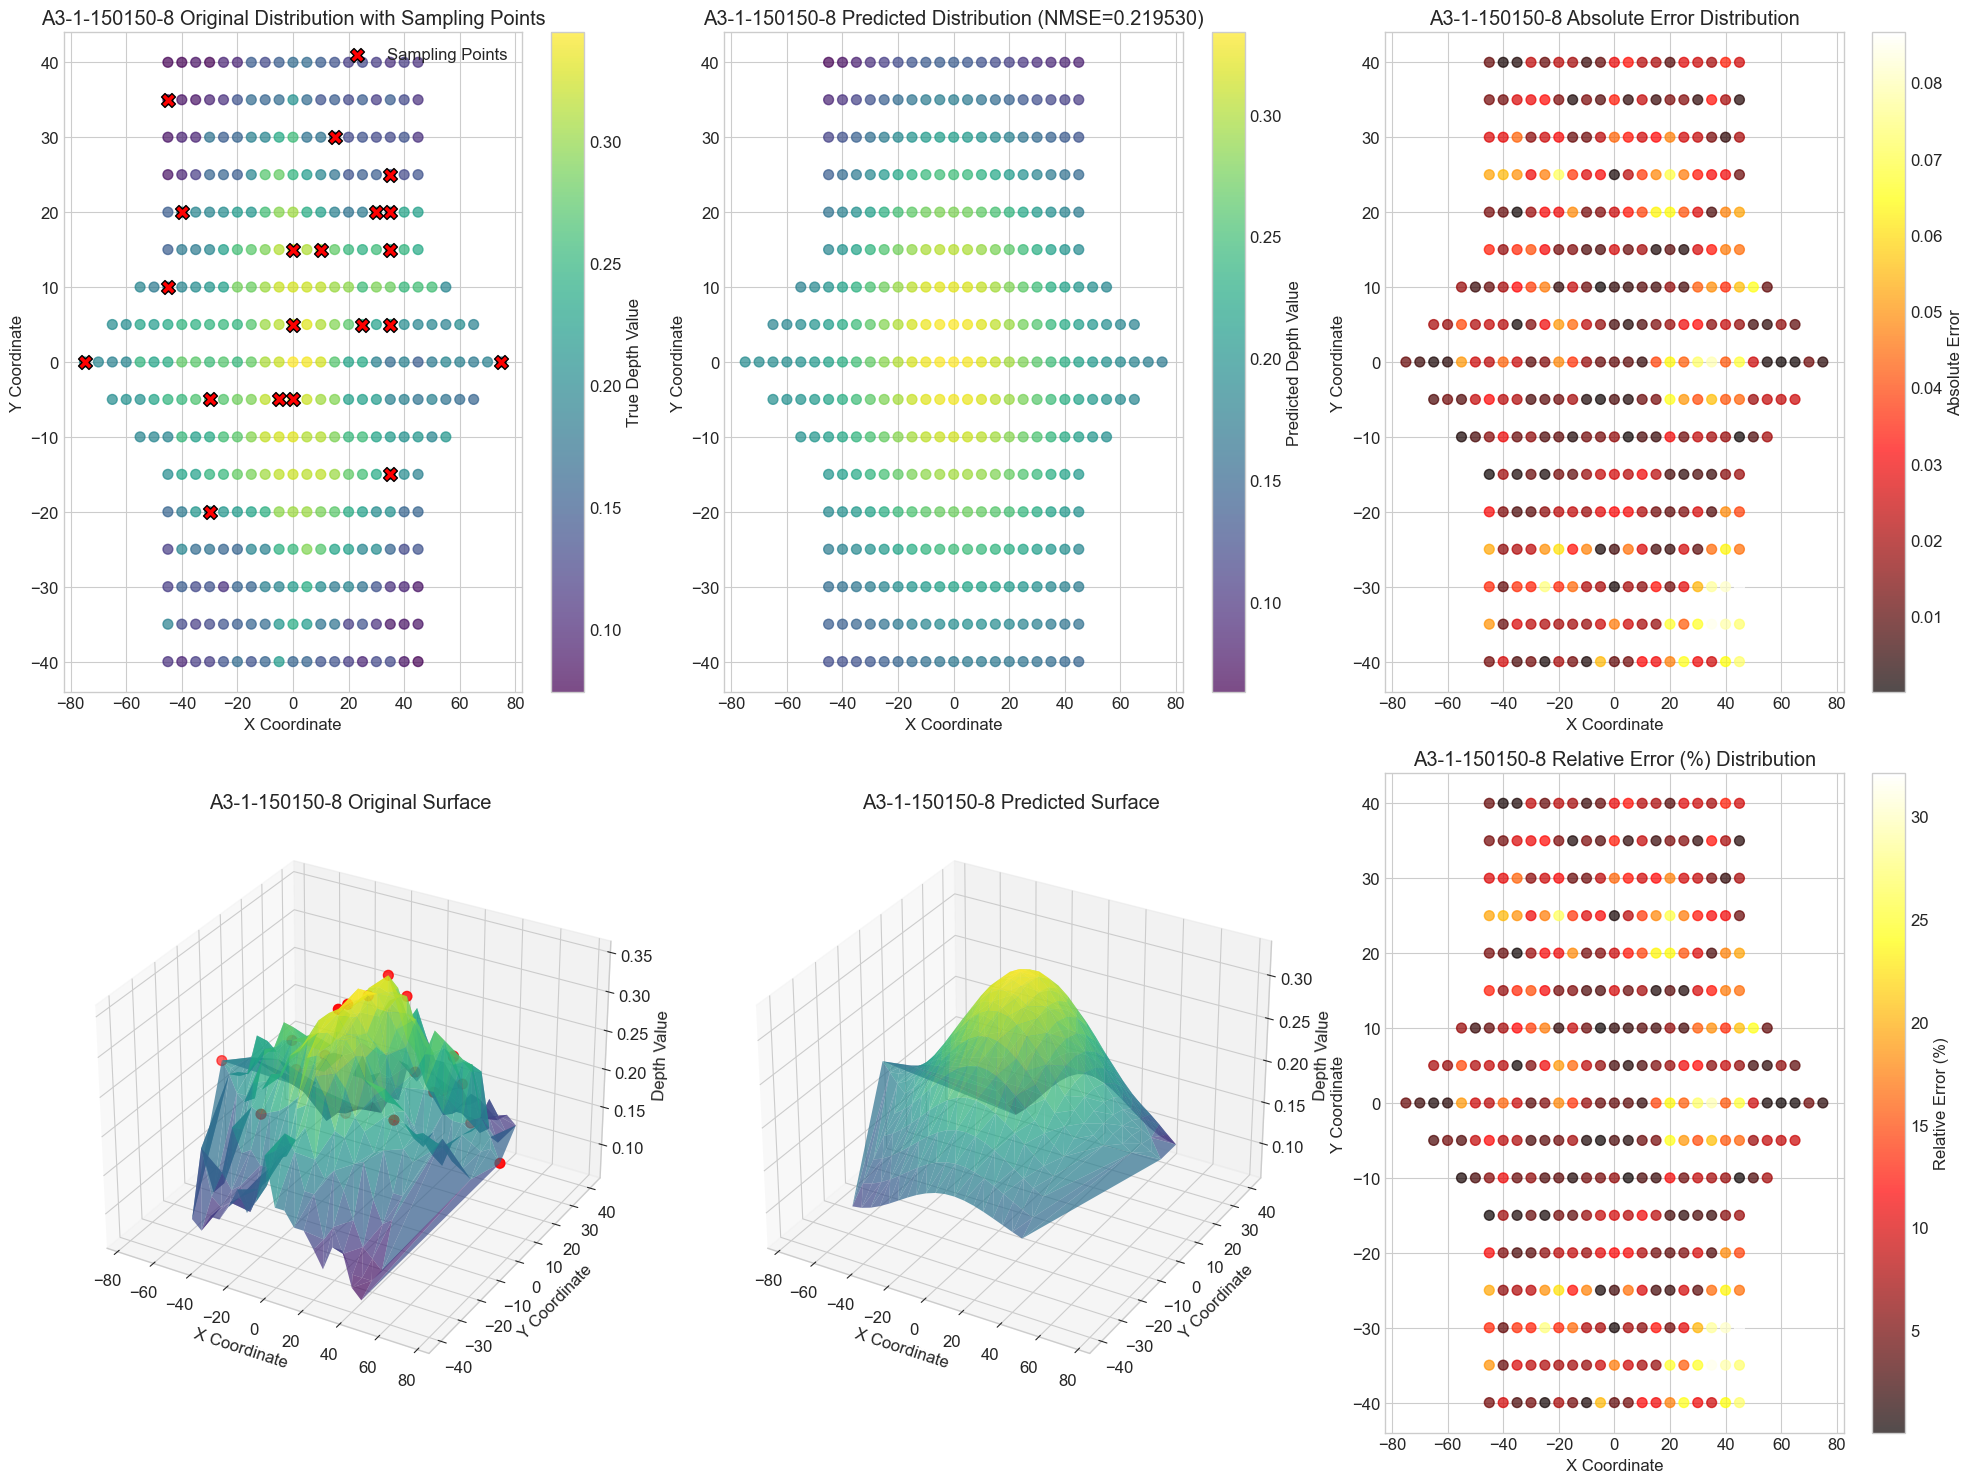

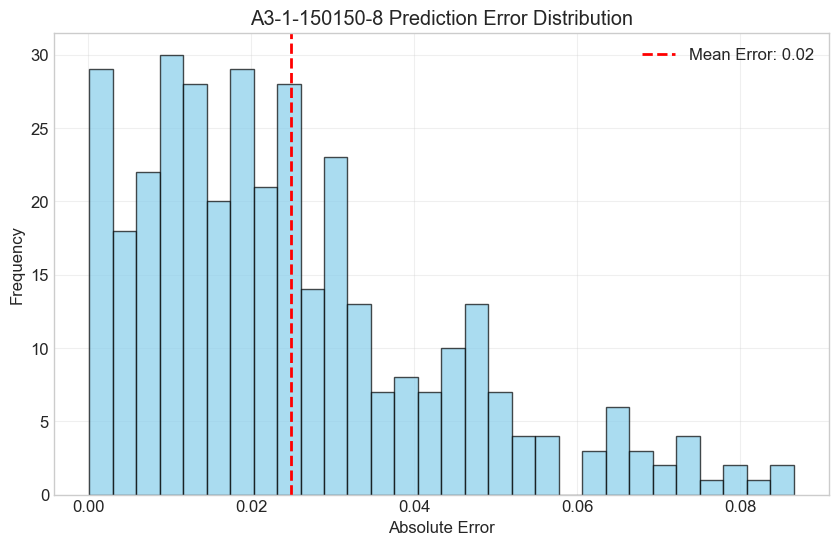


Error Statistics for A3-1-150150-8:
                    Metric      Value
0                     NMSE   0.219530
1      Mean Absolute Error   0.024824
2       Max Absolute Error   0.086578
3  Mean Relative Error (%)   9.195312
4   Max Relative Error (%)  32.070729

Generating visualizations for A3-1-150150-14...


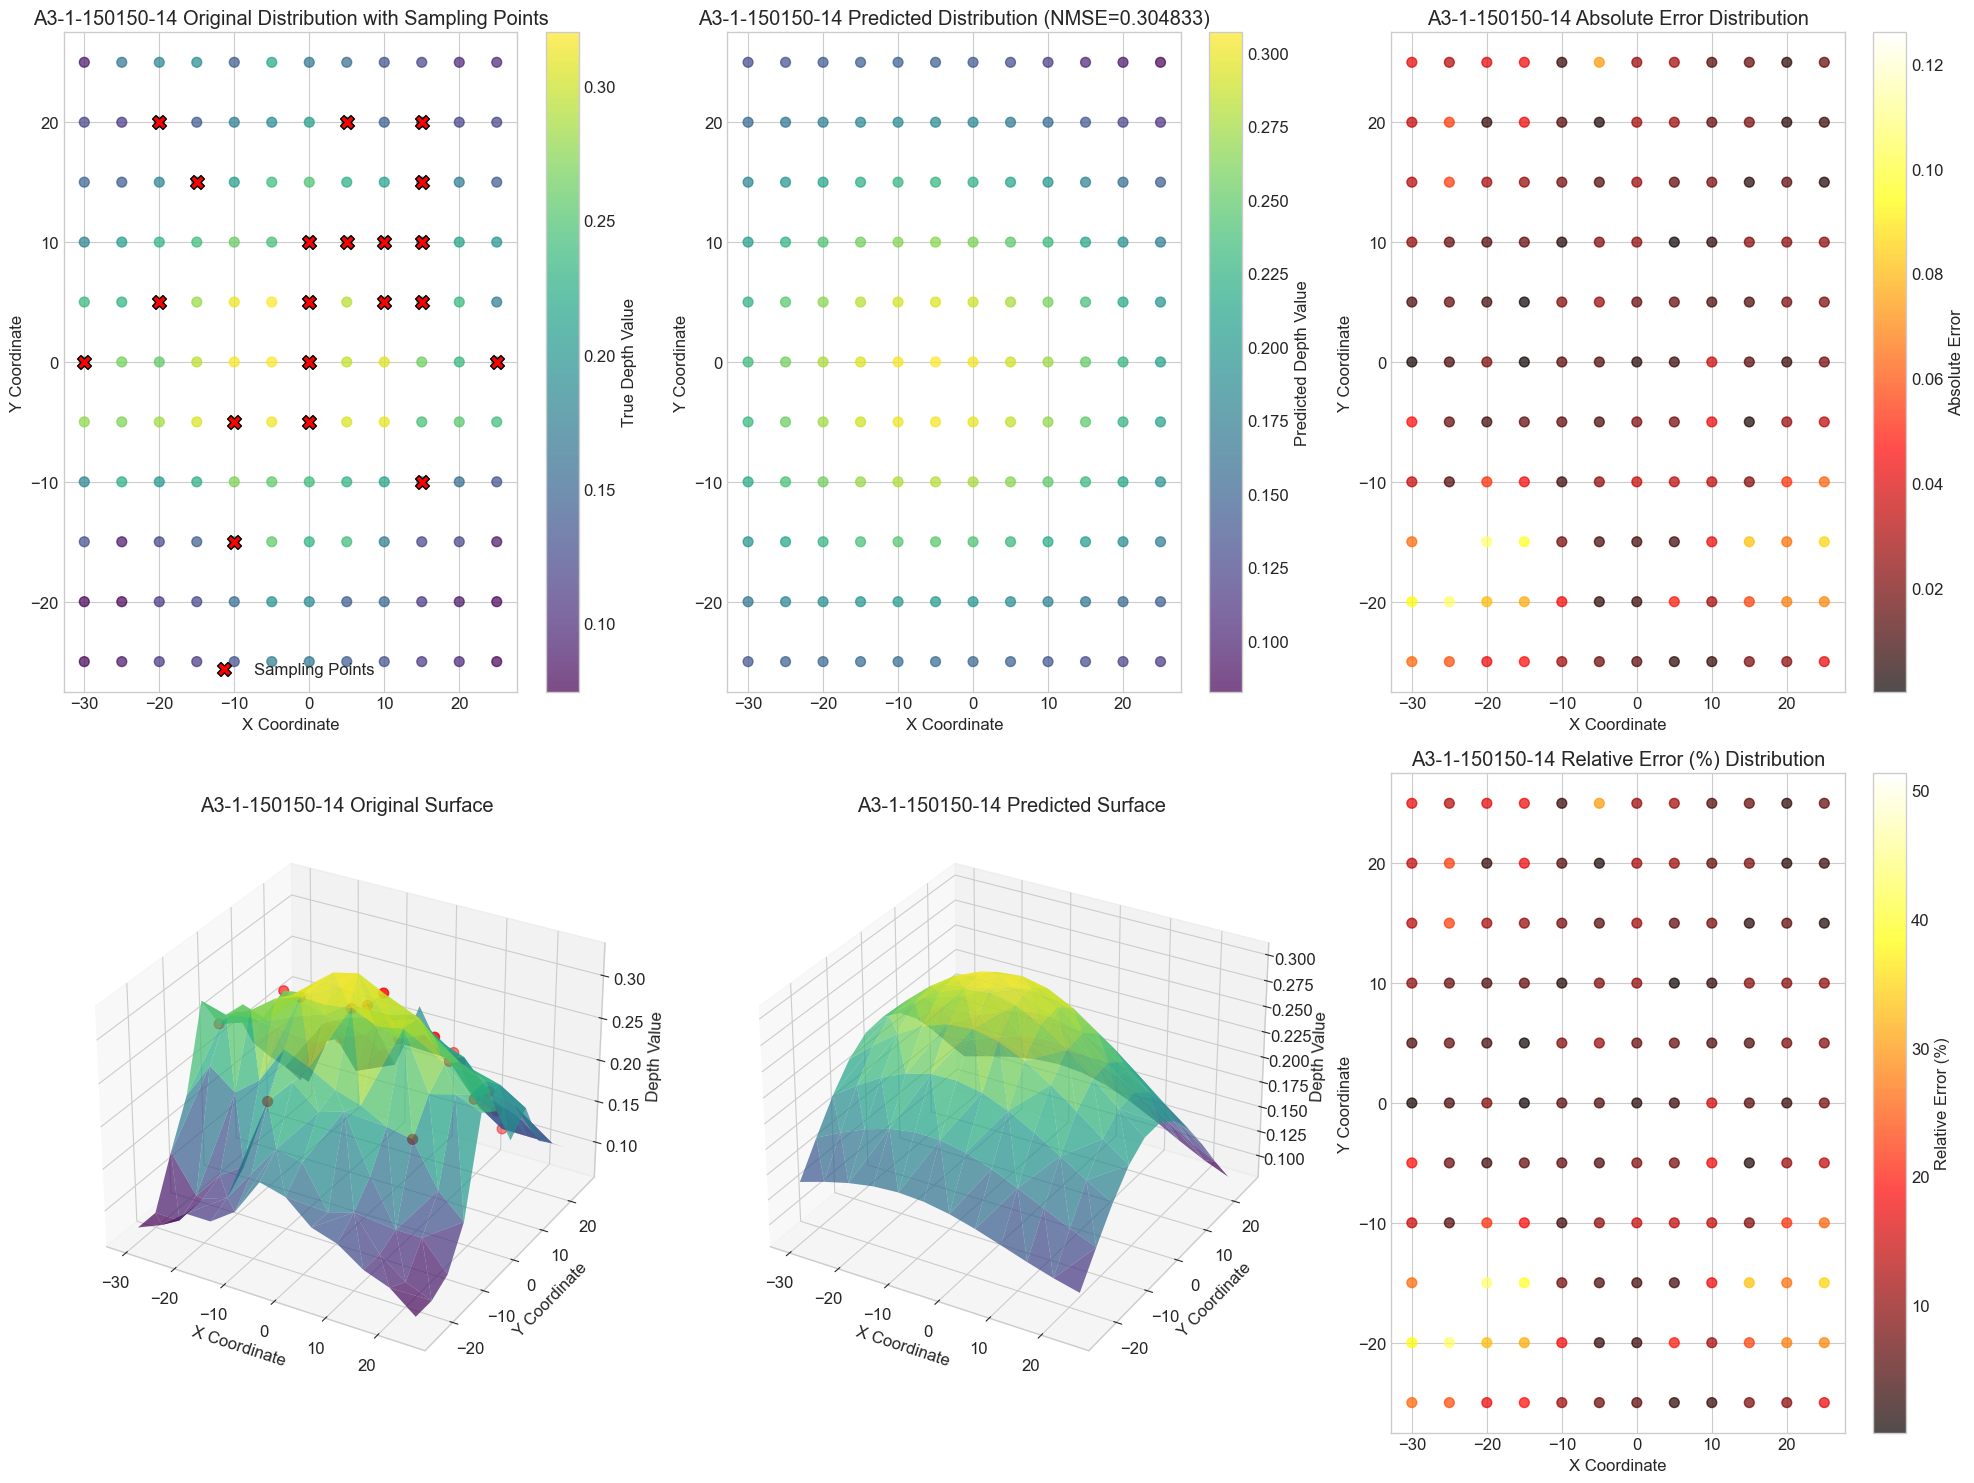

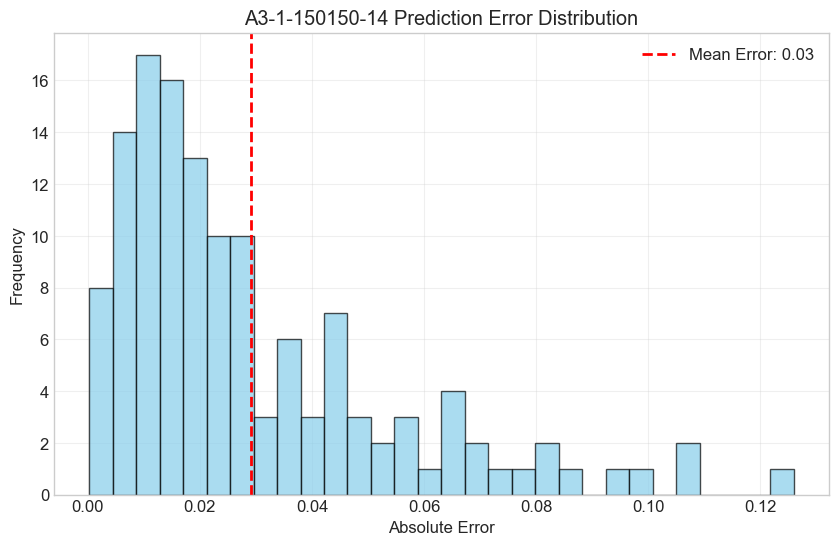


Error Statistics for A3-1-150150-14:
                    Metric      Value
0                     NMSE   0.304833
1      Mean Absolute Error   0.029129
2       Max Absolute Error   0.125987
3  Mean Relative Error (%)  11.861549
4   Max Relative Error (%)  51.302706

Generating visualizations for A3-1-150150-21...


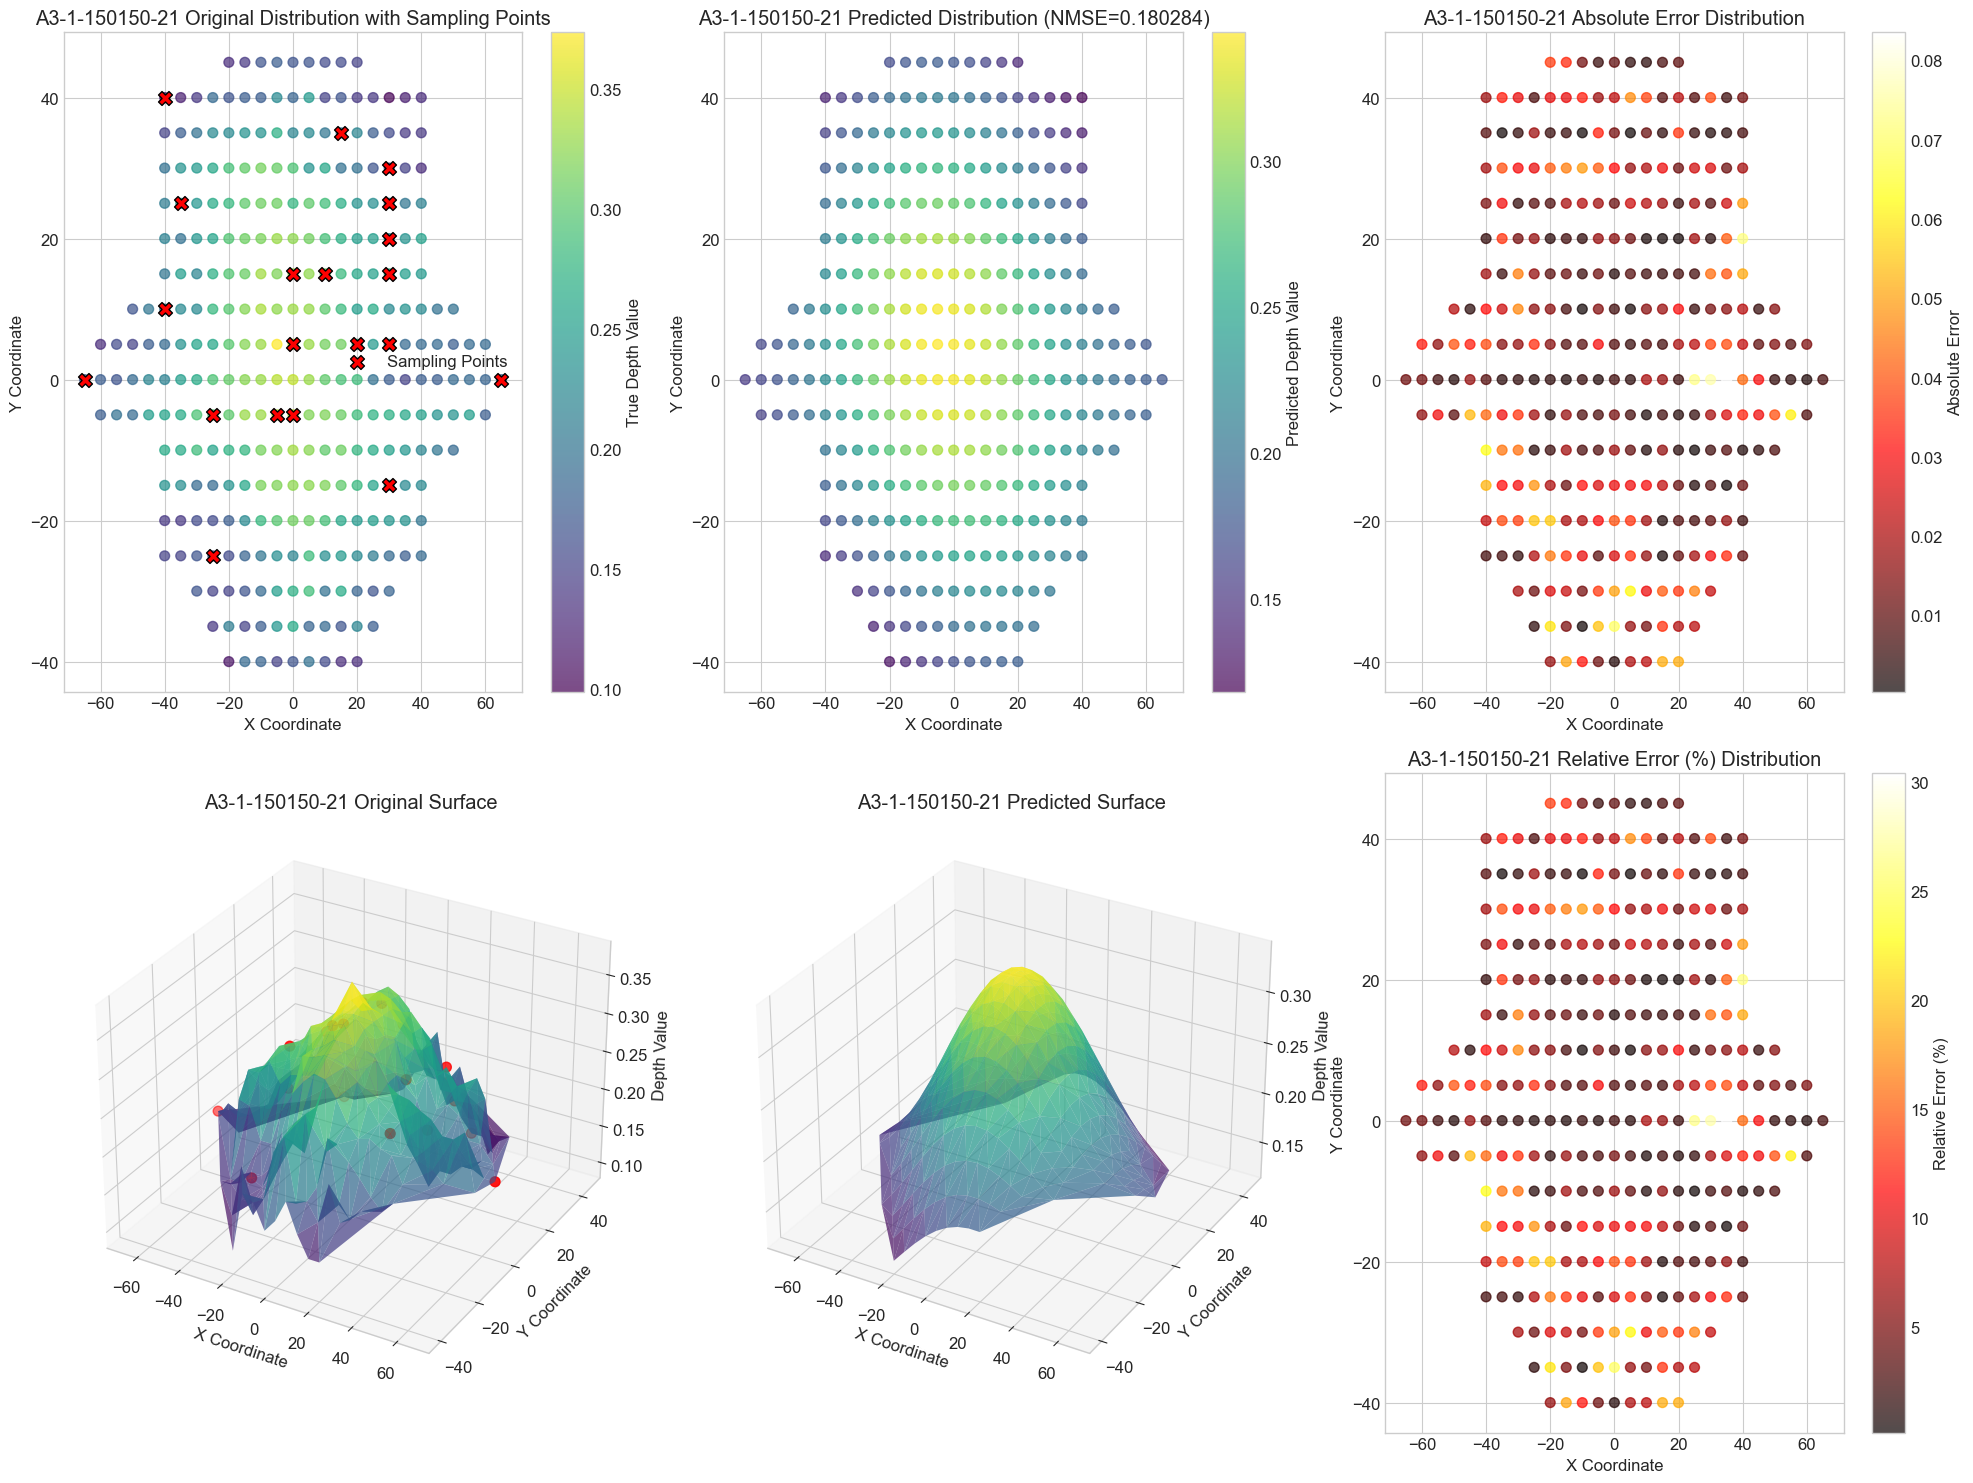

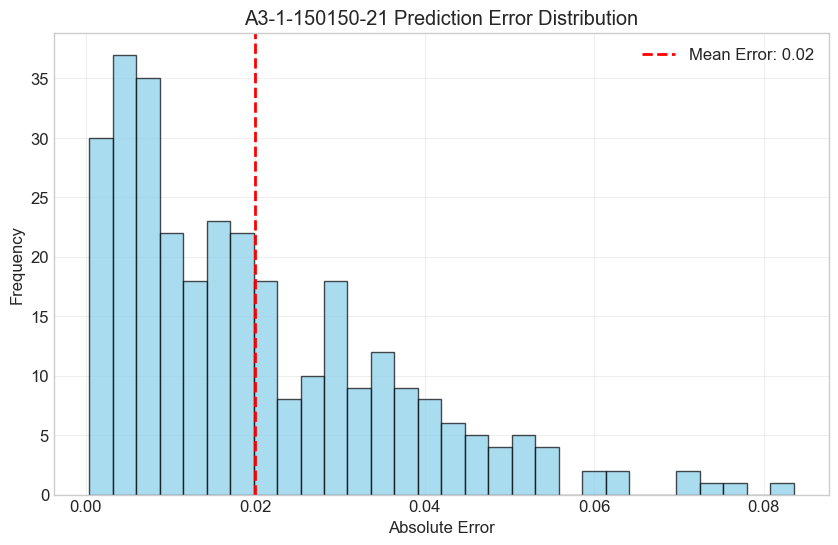


Error Statistics for A3-1-150150-21:
                    Metric      Value
0                     NMSE   0.180284
1      Mean Absolute Error   0.019947
2       Max Absolute Error   0.083544
3  Mean Relative Error (%)   7.261707
4   Max Relative Error (%)  30.414229


In [9]:
# Create comprehensive visualizations for each plate's prediction results
def visualize_prediction_results(plate_name, plate_data, result, results_dir):
    """
    Create detailed visualizations of GPR prediction results
    
    Parameters:
        plate_name: Name of the plate
        plate_data: Original plate data dictionary
        result: Prediction result dictionary
        results_dir: Directory to save results
    """
    # Extract needed data
    x = plate_data['x']
    y = plate_data['y']
    z_true = plate_data['value']
    z_pred = result['y_pred']
    error = result['absolute_error']
    rel_error = result['relative_error']
    sampling_points = result['optimized_points']
    sampling_values = result['optimized_values']
    nmse = result['nmse']
    
    # Create figure with multiple subplots for comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Original Distribution (2D Color Map)
    ax1 = fig.add_subplot(231)
    scatter1 = ax1.scatter(x, y, c=z_true, cmap='viridis', s=50, alpha=0.7)
    ax1.scatter(sampling_points[:, 0], sampling_points[:, 1], c='red', s=100, marker='X', edgecolor='black', label='Sampling Points')
    ax1.set_title(f'{plate_name} Original Distribution with Sampling Points')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.legend()
    plt.colorbar(scatter1, ax=ax1, label='True Depth Value')
    
    # 2. Predicted Distribution (2D Color Map)
    ax2 = fig.add_subplot(232)
    scatter2 = ax2.scatter(x, y, c=z_pred, cmap='viridis', s=50, alpha=0.7)
    ax2.set_title(f'{plate_name} Predicted Distribution (NMSE={nmse:.6f})')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    plt.colorbar(scatter2, ax=ax2, label='Predicted Depth Value')
    
    # 3. Absolute Error Distribution
    ax3 = fig.add_subplot(233)
    scatter3 = ax3.scatter(x, y, c=error, cmap='hot', s=50, alpha=0.7)
    ax3.set_title(f'{plate_name} Absolute Error Distribution')
    ax3.set_xlabel('X Coordinate')
    ax3.set_ylabel('Y Coordinate')
    plt.colorbar(scatter3, ax=ax3, label='Absolute Error')
    
    # 4. 3D Surface Plot - Original
    ax4 = fig.add_subplot(234, projection='3d')
    surf1 = ax4.plot_trisurf(x, y, z_true, cmap='viridis', edgecolor='none', alpha=0.7)
    ax4.scatter(sampling_points[:, 0], sampling_points[:, 1], sampling_values, 
                c='red', s=50, marker='o', label='Sampling Points')
    ax4.set_title(f'{plate_name} Original Surface')
    ax4.set_xlabel('X Coordinate')
    ax4.set_ylabel('Y Coordinate')
    ax4.set_zlabel('Depth Value')
    
    # 5. 3D Surface Plot - Predicted
    ax5 = fig.add_subplot(235, projection='3d')
    surf2 = ax5.plot_trisurf(x, y, z_pred, cmap='viridis', edgecolor='none', alpha=0.7)
    ax5.set_title(f'{plate_name} Predicted Surface')
    ax5.set_xlabel('X Coordinate')
    ax5.set_ylabel('Y Coordinate')
    ax5.set_zlabel('Depth Value')
    
    # 6. Relative Error Distribution or Histogram
    ax6 = fig.add_subplot(236)
    scatter6 = ax6.scatter(x, y, c=rel_error, cmap='hot', s=50, alpha=0.7)
    ax6.set_title(f'{plate_name} Relative Error (%) Distribution')
    ax6.set_xlabel('X Coordinate')
    ax6.set_ylabel('Y Coordinate')
    plt.colorbar(scatter6, ax=ax6, label='Relative Error (%)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'{plate_name}_prediction_results.png'), dpi=300)
    plt.show()
    
    # Additional visualization: Error histogram
    plt.figure(figsize=(10, 6))
    plt.hist(error, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(error), color='r', linestyle='--', linewidth=2, 
                label=f'Mean Error: {np.mean(error):.2f}')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title(f'{plate_name} Prediction Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(os.path.join(results_dir, f'{plate_name}_error_histogram.png'), dpi=300)
    plt.show()

    # Create a table of error statistics
    error_stats = pd.DataFrame({
        'Metric': ['NMSE', 'Mean Absolute Error', 'Max Absolute Error', 
                  'Mean Relative Error (%)', 'Max Relative Error (%)'],
        'Value': [nmse, np.mean(error), np.max(error), 
                 np.mean(rel_error), np.max(rel_error)]
    })
    
    # Print error statistics
    print(f"\nError Statistics for {plate_name}:")
    print(error_stats)
    
    # Save error statistics to CSV
    error_stats.to_csv(os.path.join(results_dir, f'{plate_name}_error_stats.csv'), index=False)

# Create visualizations for each plate
for plate_name, result in optimized_results.items():
    print(f"\nGenerating visualizations for {plate_name}...")
    visualize_prediction_results(plate_name, plates_data[plate_name], result, results_dir)



本研究表明，使用统一相对位置的20个采样点可以实现合理的硬度分布预测，为实际测量提供了一种可行的替代方案。理由如下:
1. **测量流程简化**：可以使用相同的测量模板对所有板材进行采样，减少测量过程中的复杂性
2. **标准化的方法**：为不同板材提供了一种标准化的预测方法，便于实施和管理
3. **适用范围广**：当板材具有相似的分布特征时，表现良好